# Восстановление золота из руды

## Описание проекта

Подготовим прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам нужно:
- Подготовить данные;
- Провести исследовательский анализ данных;
- Построить и обучить модель.

Технологический процесс добычи золота из руды. Изучим внимательно стадии процесса.

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.


<img src="https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg"
     alt="Этапы обработки"
     width="800"
    >


Опишем каждую стадию: 
1. Флотация
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).
2. Очистка 
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

Описание данных

Технологический процесс
- `Rougher feed` — исходное сырье
- `Rougher additions` (или `reagent additions`) — флотационные реагенты: `Xanthate`, `Sulphate`, `Depressant`
  - `Xanthate` **— ксантогенат (промотер, или активатор флотации);
  - `Sulphate` — сульфат (на данном производстве сульфид натрия);
  - `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота

Параметры этапов
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

### Наименование признаков

Наименование признаков должно быть такое:
`[этап].[тип_параметра].[название_параметра]`

Пример: `rougher.input.feed_ag`

Возможные значения для блока [этап]:
- `rougher` — флотация
- `primary_cleaner` — первичная очистка
- `secondary_cleaner` — вторичная очистка
- `final` — финальные характеристики

Возможные значения для блока [тип_параметра]:
- `input` — параметры сырья
- `output` — параметры продукта
- `state` — параметры, характеризующие текущее состояние этапа
- `calculation` — расчётные характеристики

### Расчёт эффективности

Нам нужно смоделировать процесс восстановления золота из золотосодержащей руды. 

Эффективность обогащения рассчитывается по формуле:

$$ Recovery = \frac{C * (F - T)}{F * (C - T)} $$

где:
- `C` — доля золота в концентрате после флотации/очистки;
- `F` — доля золота в сырье/концентрате до флотации/очистки;
- `T` — доля золота в отвальных хвостах после флотации/очистки.

### Метрика качества

Для решения задачи введём новую метрику качества — `sMAPE` (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).
Она похожа на `MAE`, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:

$$ {sMAPE} = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} * 100\% $$

Обозначения:

- $y_i$  Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.

- $\hat{y_i}$ Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.

- $N$ Количество объектов в выборке.

- $\sum_{i=1}^{N}$ Суммирование по всем объектам выборки (i меняется от 1 до N).

Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Итоговая метрика складывается из двух величин:

$$ {sMAPE} = 25\% * {sMAPE(rougher)}  + 75\% * {sMAPE(final)}  $$

Данные находятся в трёх файлах:
- `gold_recovery_train_new.csv` — обучающая выборка;
- `gold_recovery_test_new.csv` — тестовая выборка;
- `gold_recovery_full_new.csv` — исходные данные.

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В нашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверим по нашей инструкции их на корректность.

- 1. Подготовим данные
    - 1.1. Откроем файлы и изучите их.
        - Путь к файлам:
        - `/datasets/gold_recovery_train_new.csv.` [Скачать датасет](https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv "gold_recovery_train_new.csv")
        - `/datasets/gold_recovery_test_new.csv.` [Скачать датасет](https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv "gold_recovery_test_new.csv")
        - `/datasets/gold_recovery_full_new.csv.` [Скачать датасет](https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv "gold_recovery_full_new.csv")
    - 1.2. Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака `rougher.output.recovery`. Найдите `MAE` между вашими расчётами и значением признака. Опишем выводы.
    - 1.3. Проанализируем признаки, недоступные в тестовой выборке.
    - 1.4. Проведем предобработку данных.
- 2. Проанализируем данные
    - 2.1. Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишием выводы.
    - 2.2. Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. (Если распределения сильно отличаются друг от друга, оценка модели будет неправильной).
    - 2.3. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 
- 3. Построим модель
    - 3.1. Напишем функцию для вычисления итоговой `sMAPE`.
    - 3.2. Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель и проверим её на тестовой выборке. Опишем выводы.

## Подготовка данных

### Загрузка и осмотр

In [1]:
# отключим предупреждающие уведомления
import warnings
warnings.filterwarnings('ignore')

# Добавим основные библиотеки
import pandas as pd
import numpy as np
import os.path
import math

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(world_readable=True, theme='henanigans', offline=True)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

# установим необходимые компониенты из библиотеки ылдуфкт для построения моделей
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Сделаем небольшие настройки pandas для комфортного отображения проекта
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.mode.chained_assignment = None

### Импортируем датасеты методом try/except и установим индексом столбец date

In [2]:
try:
    path_train = os.path.join('datasets/gold_recovery_train_new.csv', index_col='date')
    train = pd.read_csv(path_train)
except:
    train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv', index_col='date')

train = train.set_index(pd.DatetimeIndex(train.index))

try:
    path_test = os.path.join('datasets/gold_recovery_test_new.csv', index_col='date')
    test = pd.read_csv(path_test)
except:
    test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv', index_col='date')

test = test.set_index(pd.DatetimeIndex(test.index))

try:
    path_full = os.path.join('datasets/gold_recovery_full_new.csv', index_col='date')
    full = pd.read_csv(path_full)
except:
    full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv', index_col='date')

full = full.set_index(pd.DatetimeIndex(full.index))

### Посмотрим на данные

In [3]:
def first_view(data):
    title_lenght = 79
    title_one = 'Обзор данных первых и последних пяти строк'
    print('~' * int((title_lenght - len(title_one)) / 2), title_one, '~' * (title_lenght - len(title_one) - int((title_lenght - len(title_one)) / 2)))
    display(data.head(5))
    display(data.tail(5))
    print()
    title_two = 'Основная описательная статистика'
    print('~' * int((title_lenght - len(title_two)) / 2), title_two, '~' * (title_lenght - len(title_two) - int((title_lenght - len(title_two)) / 2)))
    display(data.describe())
    print()
    title_three = 'Тип данных' 
    print('~' * int((title_lenght - len(title_three)) / 2), title_three, '~' * (title_lenght - len(title_three) - int((title_lenght - len(title_three)) / 2)))
    data.info()
    print()
    title_four = 'Пропуски'
    print('~' * int((title_lenght - len(title_four)) / 2), title_four, '~' * (title_lenght - len(title_four) - int((title_lenght - len(title_four)) / 2)))
    all_nulls = 0
    for col in data.columns:
       if data[col].isna().sum() > 0:
            all_nulls += 1
            print(f"{data[col].isna().sum()} пропусков в колонке {col}. Это {round(data[col].isna().mean() * 100, 2)}%")
    if all_nulls == 0:
        print('В датасете нет пропусков')
    print()
    title_five = 'Явные дубликаты'
    print('~' * int((title_lenght - len(title_five)) / 2), title_five, '~' * (title_lenght - len(title_five) - int((title_lenght - len(title_five)) / 2)))
    if data.duplicated().sum() > 0:
        print('найдено дубликатов - ', data.duplicated().sum(), 'шт.')
    else:
        print('Дубликатов не найдено')
    print()

In [4]:
datasets = {'Тренировочная выборка': train, 'Тестовая выборка': test, 'Полный датасет': full}

for name, dataset in datasets.items():
    print('***', name, '***')
    first_view(dataset)
    print()

*** Тренировочная выборка ***
~~~~~~~~~~~~~~~~~~ Обзор данных первых и последних пяти строк ~~~~~~~~~~~~~~~~~~~


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,1549.78,-498.91,1551.43,-516.40,1549.87,-498.67,1554.37,-493.43,41885.71,3481.78,3520.34,2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,1603.01,-434.72,1602.38,-442.20,1598.94,-451.29,1404.47,-455.46,1416.35,-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,1576.17,-500.90,1575.95,-499.87,1575.99,-499.32,1574.48,-498.93,42050.86,3498.37,3489.98,2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,1000.29,-400.07,1600.75,-449.95,1600.48,-449.83,1600.53,-449.95,1399.23,-4

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.22,11.36,6.80,46.71,73.76,8.77,3.14,10.40,1.53,123.38,8.03,6.50,1.30,6.56,12.45,7.06,32.94,22.85,6.53,3.93,2.31,1648.42,-400.38,1648.74,-400.36,1648.58,-399.36,1648.83,-399.67,45912.94,2497.65,2499.18,1.16,6.09,4.62,560.89,85.72,37.37,5.34,7.76,9.16,7.77,9.16,11.12,10.98,30.07,18.60,89.57,4.21,0.61,16.67,0.75,1199.25,-300.85,1149.81,-498.79,1047.96,-498.41,946.64,-499.15,849.66,-499.21,849.76,-497.45,0.00,0.00,0.00,0.00,35.04,-499.05,29.91,-499.98,26.00,-499.95,22.99,-499.97,23.03,-501.17,20.01,-499.74,18.01,-499.83,13.00,-500.16,20.01,-501.30
2018-08-18 07:59:59,3.20,11.35,6.86,46.87,69.05,8.90,3.13,10.55,1.61,120.88,7.96,6.50,1.30,6.61,12.62,7.54,32.93,23.00,6.63,4.09,2.46,1649.82,-399.93,1649.36,-399.72,1648.66,-401.20,1649.73,-400.64,46200.10,2614.40,2518.55,1.17,6.12,4.14,559.03,119.50,38.59,4.84,7.36,9.30,7.10,9.30,11.43,10.89,29.78,18.44,87.72,4.18,0.65,16.96,0.77,1196.57,-299.51,1147.68,-500.61,1048.57,-500.93,949.77,-500.02,848.52,-500.29,85


~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.00,14148.00,13938.00,14149.00,14149.00,14149.00,14049.00,14144.00,14149.00,14129.00,14117.00,14149.00,14049.00,14149.00,14063.00,13863.00,14149.00,14148.00,14134.00,14103.00,14149.00,14145.00,14148.00,14145.00,14148.00,14147.00,14148.00,14146.00,14148.00,14148.00,14148.00,14148.00,14149.00,14149.00,14049.00,14141.00,14005.00,14071.00,14149.00,14120.00,14141.00,14113.00,13721.00,14149.00,14149.00,14127.00,14149.00,14149.00,14148.00,14149.00,14149.00,14149.00,14148.00,14148.00,14148.00,14148.00,14148.00,14148.00,14149.00,14149.00,13713.00,14149.00,14149.00,14149.00,14147.00,14139.00,12544.00,14149.00,13932.00,14148.00,14128.00,14148.00,14145.00,14148.00,14148.00,14148.00,14143.00,14148.00,14148.00,14148.00,14148.00,14148.00,14148.00,14148.00,14147.00,14148.00
mean,5.14,10.13,9.20,44.00,66.52,9.61,2.60,10.51,2.92,133.32,8.87,7.32,0.89,8.20,9.59,10.11,32.39,16.30,3.44,7.53,3.84,1608.00,-488.78,1608.61,-489.17,1608.88,-489.61,1542.19,-483.46,40382.65,3456.61,3253.36,2.37,8.58,3.52,474.03,60.11,36.31,7.87,11.76,5.85,11.37,5.89,11.78,7.66,28.30,19.44,82.70


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                  

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.80,14.99,8.08,1.01,1398.98,-500.23,1399.14,-499.92,1400.10,-500.70,1399.00,-499.49,13.13,5.64,489.79,62.71,42.02,12.08,16.92,6.15,16.87,6.15,1001.85,-350.30,1249.74,-399.11,1249.75,-399.40,1198.29,-399.49,999.47,-399.53,949.57,-398.18,24.94,-500.49,14.95,-500.01,20.02,-450.40,13.99,-449.83,12.02,-497.80,8.02,-501.29,7.95,-432.32,4.87,-500.04,26.71,-499.71
2016-09-01 01:59:59,215.39,14.99,8.08,0.99,1398.78,-500.06,1398.06,-499.78,1396.15,-499.24,1399.51,-500.42,13.04,5.53,490.10,61.96,41.19,11.92,17.00,6.00,17.00,6.00,998.69,-350.43,1248.40,-399.95,1249.51,-399.63,1200.51,-399.94,1000.00,-399.49,950.20,-405.79,24.92,-499.81,14.93,-500.76,19.99,-450.11,14.09,-450.06,12.06,-498.70,8.13,-499.63,7.96,-525.84,4.88,-500.16,25.02,-499.82
2016-09-01 02:59:59,215.26,12.88,7.79,1.00,1398.49,-500.87,1398.86,-499.76,1398.08,-502.15,1399.50,-499.72,13.14,5.43,489.62,66.90,42.55,12.09,16.99,5.85,16.98,5.85,998.52,-349.78,1247.44,-400.26,1248.21,-401.07,1199.77,-400.79,999.93,-399.24,950.32,-400.86,24.91,-500.30,15.00,-500.99,20.04,-450.26,14.08,-449.66,11.96,-498.77,8.10,-500.83,8.07,-500.80,4.91,-499.83,24.99,-500.62
2016-09-01 03:59:59,215.34,12.01,7.64,0.86,1399.62,-498.86,1397.44,-499.21,1400.13,-498.36,1401.07,-501.04,12.40,5.11,476.62,59.87,41.06,12.18,16.53,5.80,16.52,5.80,1000.28,-350.17,1251.32,-398.66,1250.49,-399.75,1199.40,-397.50,1001.93,-400.44,950.74,-399.80,24.89,-499.38,14.92,-499.86,20.03,-449.37,14.01,-449.53,12.03,-498.35,8.07,-499.47,7.90,-500.87,4.93,-499.96,24.95,-498.71
2016-09-01 04:59:59,199.10,10.68,7.53,0.81,1401.27,-500.81,1398.13,-499.50,1402.17,-500.81,1399.48,-499.37,11.33,4.77,488.25,63.32,41.27,11.29,13.61,5.74,13.65,5.74,996.54,-350.56,1304.66,-399.51,1306.46,-399.05,1248.70,-400.88,1058.84,-398.99,949.65,-399.28,24.89,-499.36,14.98,-500.19,19.96,-450.64,14.01,-450.02,12.03,-500.79,8.05,-500.40,8.11,-509.53,4.96,-500.36,25.00,-500.86


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-31 19:59:59,173.96,15.96,8.07,0.90,1401.93,-499.73,1401.44,-499.19,1399.81,-499.60,1400.33,-499.24,11.64,4.70,521.69,66.76,42.02,10.55,10.11,7.20,10.11,7.20,1399.94,-300.00,1049.64,-500.07,951.92,-499.65,852.34,-498.46,851.44,-500.29,851.46,-499.74,21.91,-499.92,19.91,-499.73,24.94,-500.10,12.97,-499.95,14.00,-500.16,12.07,-499.67,7.98,-499.52,5.93,-499.97,8.99,-499.76
2017-12-31 20:59:59,172.91,16.00,8.07,0.90,1447.08,-494.72,1448.85,-465.96,1443.89,-503.59,1447.65,-480.40,11.34,4.48,530.20,62.56,41.10,10.25,9.98,7.20,9.98,7.20,1406.12,-299.06,1055.72,-498.25,956.85,-497.40,855.39,-495.70,852.07,-499.44,851.33,-496.58,25.32,-497.03,23.31,-498.89,26.37,-499.22,17.70,-499.55,16.75,-496.03,13.37,-499.12,9.29,-496.89,7.37,-499.94,8.99,-499.90
2017-12-31 21:59:59,171.14,15.99,8.07,1.17,1498.84,-501.77,1499.57,-495.52,1502.75,-520.67,1502.59,-498.26,11.29,4.41,546.31,73.65,41.10,10.17,10.18,7.20,10.19,7.20,1396.20,-300.21,1047.88,-499.60,948.96,-499.55,856.33,-500.10,850.61,-499.47,850.28,-498.51,29.08,-500.53,26.89,-500.98,28.00,-500.57,23.00,-500.48,19.99,-499.79,15.10,-499.94,10.99,-498.35,9.02,-500.04,8.98,-497.79
2017-12-31 22:59:59,179.70,15.44,8.07,1.50,1498.47,-500.48,1497.99,-519.20,1496.57,-487.48,1502.69,-501.57,11.29,4.34,547.33,78.07,41.72,10.07,10.73,7.20,10.73,7.20,1403.94,-300.03,1049.80,-499.80,950.77,-500.37,847.65,-499.92,849.41,-500.38,850.08,-500.48,29.10,-499.69,27.05,-499.86,27.98,-499.91,23.05,-499.74,19.96,-499.96,15.03,-499.72,11.01,-499.99,9.01,-499.94,9.01,-500.15
2017-12-31 23:59:59,181.56,15.00,8.07,1.62,1498.10,-499.80,1501.74,-505.15,1499.54,-492.43,1499.67,-499.77,10.90,4.09,564.54,77.68,40.89,9.70,10.79,7.20,10.79,7.20,1400.61,-299.99,1052.78,-499.76,950.79,-499.36,850.64,-500.43,850.37,-500.82,850.68,-498.54,29.10,-500.43,26.89,-500.09,28.02,-500.17,23.01,-500.22,20.03,-500.73,14.91,-499.95,10.99,-500.66,8.99,-500.34,8.99,-500.76



~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.00,5285.00,5290.00,5286.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5287.00,5289.00,5269.00,5290.00,5285.00,5290.00,5282.00,5265.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5287.00,5290.00,5288.00,5290.00,5281.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00,5290.00
mean,174.84,8.68,7.27,1.38,1539.49,-497.67,1545.17,-500.27,1527.27,-498.33,1544.84,-500.20,9.37,3.80,489.80,55.95,37.72,9.33,13.86,6.47,13.92,6.51,1053.40,-395.73,1318.93,-475.24,1301.60,-474.84,1214.85,-475.68,1056.65,-469.03,997.95,-470.48,26.31,-502.75,21.95,-501.99,25.40,-507.49,20.98,-506.63,16.32,-505.14,13.74,-463.35,12.80,-501.33,9.88,-495.66,17.30,-501.79
std,43.03,3.07,0.61,0.64,116.80,19.95,122.22,32.97,122.54,21.96,124.77,31.05,1.93,0.95,108.04,19.08,5.49,1.62,3.35,1.07,3.22,0.89,121.14,91.09,156.45,45.65,171.27,45.86,185.76,47.84,131.54,59.33,128.22,60.76,3.43,28.76,4.35,34.58,6.53,47.62,6.74,44.53,3.49,31.43,3.43,86.19,3.03,17.95,2.87,34.54,4.54,39.04
min,2.57,0.00,5.65,0.00,0.00,-795.32,0.00,-800.00,0.00,-799.96,0.00,-799.79,0.57,0.27,0.00,0.05,1.39,0.57,0.00,0.00,0.00,0.01,-0.04,-657.95,-0.72,-650.25,-0.06,-647.54,-0.99,-648.39,-1.98,-649.27,-2.59,-649.95,0.21,-784.09,0.01,-797.78,0.00,-799.76,0.00,-809.33,0.00,-799.80,0.00,-800.84,0.07,-797.32,0.53,-800.22,-0.08,-809.74
25%,147.12,6.49,6.89,0.91,1498.94,-500.36,1498.97,-500.70,1473.23,-501.02,1499.48,-500.45,8.11,3.24,407.02,43.91,34.51,8.21,12.00,6.00,12.00,6.00,999.21,-499.92,1200.87,-500.26,1199.65,-500.23,1093.37,-500.44,999.36,-500.19,901.02,-500.62,24.94,-500.21,20.00,-500.22,22.98,-500.30,17.97,-500.15,14.04,-500.87,12.03,-500.32,10.91,-500.73,8.04,-500.19,14.00,-500.69
50%,177.83,8.05,7.25,1.20,1585.13,-499.97,1595.62,-500.03,1549.59,-500.02,1594.58,-500.02,9.76,3.74,499.05,50.84,37.98,9.59,14.00,6.50,14.00,6.50,1000.47,-399.69,1302.25,-499.84,1300.20,-499.78,1207.01,-499.69,1047.50,-499.77,999.44,-499.68,26.91,-500.00,22.94,-500.02,25.01,-500.03,21.00,-500.01,17.01,-500.12,14.96,-499.58,12.95,-499.99


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air 

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.06,9.89,5.51,42.19,70.54,10.41,0.90,16.90,2.14,127.09,10.13,7.25,0.99,8.55,10.39,19.53,34.17,14.94,2.53,7.48,2.11,1549.78,-498.91,1551.43,-516.40,1549.87,-498.67,1554.37,-493.43,41885.71,3481.78,3520.34,2.84,6.10,2.28,523.55,55.49,36.81,6.49,11.99,6.01,11.84,6.01,11.50,7.10,28.03,19.79,87.11,5.01,0.51,19.15,1.17,999.71,-404.07,1603.01,-434.72,1602.38,-442.20,1598.94,-451.29,1404.47,-455.46,1416.35,-451.94,14.50,4.69,8.76,2.61,25.85,-498.53,23.89,-501.41,23.96,-495.26,21.94,-499.34,14.02,-502.49,12.10,-504.72,9.93,-498.31,8.08,-500.47,14.15,-605.84
2016-01-15 01:00:00,6.03,9.97,5.26,42.70,69.27,10.46,0.93,16.63,2.22,125.63,10.30,7.25,1.00,8.56,10.50,19.37,34.12,16.25,3.05,6.73,2.35,1576.17,-500.90,1575.95,-499.87,1575.99,-499.32,1574.48,-498.93,42050.86,3498.37,3489.98,2.86,6.16,2.27,525.29,57.28,35.75,6.48,11.97,6.01,12.00,6.01,11.62,7.28,28.07,20.05,86.84,4.96,0.54,18.97,1.18,1000.29,-400.07,1600.75,-449.95,1600.48,-449.83,1600.53,-449.95,1399.23,-4

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-08-18 06:59:59,3.22,11.36,6.80,46.71,73.76,8.77,3.14,10.40,1.53,123.38,8.03,6.50,1.30,6.56,12.45,7.06,32.94,22.85,6.53,3.93,2.31,1648.42,-400.38,1648.74,-400.36,1648.58,-399.36,1648.83,-399.67,45912.94,2497.65,2499.18,1.16,6.09,4.62,560.89,85.72,37.37,5.34,7.76,9.16,7.77,9.16,11.12,10.98,30.07,18.60,89.57,4.21,0.61,16.67,0.75,1199.25,-300.85,1149.81,-498.79,1047.96,-498.41,946.64,-499.15,849.66,-499.21,849.76,-497.45,0.00,0.00,0.00,0.00,35.04,-499.05,29.91,-499.98,26.00,-499.95,22.99,-499.97,23.03,-501.17,20.01,-499.74,18.01,-499.83,13.00,-500.16,20.01,-501.30
2018-08-18 07:59:59,3.20,11.35,6.86,46.87,69.05,8.90,3.13,10.55,1.61,120.88,7.96,6.50,1.30,6.61,12.62,7.54,32.93,23.00,6.63,4.09,2.46,1649.82,-399.93,1649.36,-399.72,1648.66,-401.20,1649.73,-400.64,46200.10,2614.40,2518.55,1.17,6.12,4.14,559.03,119.50,38.59,4.84,7.36,9.30,7.10,9.30,11.43,10.89,29.78,18.44,87.72,4.18,0.65,16.96,0.77,1196.57,-299.51,1147.68,-500.61,1048.57,-500.93,949.77,-500.02,848.52,-500.29,85


~~~~~~~~~~~~~~~~~~~~~~~ Основная описательная статистика ~~~~~~~~~~~~~~~~~~~~~~~~


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.00,19438.00,19228.00,19439.00,19439.00,19438.00,19338.00,19433.00,19439.00,19415.00,19402.00,19439.00,19335.00,19439.00,19323.00,19069.00,19439.00,19435.00,19418.00,19377.00,19439.00,19435.00,19438.00,19435.00,19438.00,19437.00,19438.00,19436.00,19438.00,19437.00,19437.00,19437.00,19439.00,19439.00,19339.00,19428.00,19294.00,19340.00,19439.00,19405.00,19431.00,19395.00,18986.00,19439.00,19439.00,19416.00,19439.00,19439.00,19438.00,19439.00,19439.00,19439.00,19438.00,19438.00,19438.00,19438.00,19438.00,19438.00,19439.00,19439.00,19003.00,19439.00,19439.00,19439.00,19437.00,19427.00,17691.00,19439.00,19219.00,19438.00,19416.00,19438.00,19426.00,19438.00,19438.00,19438.00,19433.00,19438.00,19438.00,19438.00,19438.00,19438.00,19438.00,19438.00,19437.00,19438.00
mean,5.17,9.98,9.50,44.08,67.05,9.69,2.71,10.58,3.04,144.62,8.82,7.31,1.02,8.44,9.83,10.49,32.12,16.15,3.44,7.97,3.91,1589.35,-491.20,1591.34,-492.19,1586.67,-491.98,1542.91,-488.02,42171.19,3393.05,3256.85,2.42,8.79,3.60,478.32,58.97,36.70,8.27,12.33,6.02,12.06,6.07,11.99,7.61,28.81,19.77,83.33,


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Тип данных ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                  

### Посмотрим гистограммы

In [5]:
# # Раскомментируйте строку кода под этим комментарием, если вы хотите запустить этот проект локально и посмотреть гистограммы в интерактивном режиме
# # Чтобы проанализировать отдельные гистограммы для каждого столбца, дважды щелкните по имени столбца в списке справа (если все показаны)
# # щелкните по следующему (если он показан) или щелкните по тому, который вы хотите удалить. Таким образом можно проанализировать любые комбинации параметров до конца.
# # Я скрыл вывод этого кода перед загрузкой на GitHub, из за ограничения в 100мб веса файла и добавлил скриншоты, чтобы вы могли видеть результат этого кода

# full.iplot(kind='hist', title='Анализ гистограмм', xTitle='Значение', yTitle='Количество');

<img src="img/final_output_concentratrate.png"
     alt="Final output concentratrate"
     width="1200"
    >

<img src="img/final_output_recovery.png"
     alt="Final output recovery"
     width="1200"
    >

<img src="img/final_output_tail.png"
     alt="Final output tail"
     width="1200"
    >

<img src="img/primary_cleaner_input.png"
     alt="Primary cleaner input"
     width="1200"
    >

<img src="img/primary_cleaner_output_concentrate.png"
     alt="Primary cleaner output concentrate"
     width="1200"
    >

<img src="img/primary_cleaner_output_tail.png"
     alt="Primary cleaner output tail"
     width="1200"
    >

<img src="img/primary_cleaner_state_floatbank8_air.png"
     alt="Primary cleaner state floatbank8 air"
     width="1200"
    >

<img src="img/primary_cleaner_state_floatbank8_level.png"
     alt="Primary cleaner state floatbank8 level"
     width="1200"
    >

<img src="img/rougher_calculation_au_pb_ratio.png"
     alt="Rougher calculation au pb ratio"
     width="1200"
    >

<img src="img/rougher_calculation_floatbanks10-11_sulfate_to_au.png"
     alt="Rougher calculation floatbanks10-11 sulfate to au"
     width="1200"
    >

<img src="img/rougher_calculation_sulfate_to_au_concentrate.png"
     alt="Rougher calculation sulfate to au concentrate"
     width="1200"
    >

<img src="img/rougher_input_feed_rate_n_size.png"
     alt="Rougher input feed rate n size"
     width="1200"
    >

<img src="img/rougher_input_feed_x.png"
     alt="Rougher input feed x"
     width="1200"
    >

<img src="img/rougher_input_floatbank10.png"
     alt="Rougher input floatbank10"
     width="1200"
    >

<img src="img/rougher_input_floatbank11.png"
     alt="Rougher input floatbank11"
     width="1200"
    >

<img src="img/rougher_output_concentrate.png"
     alt="Rougher output concentrate"
     width="1200"
    >

<img src="img/rougher_output_recovery.png"
     alt="Rougher output recovery"
     width="1200"
    >

<img src="img/rougher_output_tail.png"
     alt="Rougher output tail"
     width="1200"
    >

<img src="img/rougher_state_floatbank10_air.png"
     alt="Rougher state floatbank10 air"
     width="1200"
    >

<img src="img/rougher_state_floatbank10_level.png"
     alt="Rougher state floatbank10 level"
     width="1200"
    >

<img src="img/secondary_cleaner_output.png"
     alt="Secondary cleaner output"
     width="1200"
    >

<img src="img/secondary_cleaner_state_floatbank2-6_a-b_air.png"
     alt="Secondary cleaner state floatbank2-6 a-b air"
     width="1200"
    >

<img src="img/secondary_cleaner_state_floatbank2-6_a-b_level.png"
     alt="Secondary cleaner state floatbank2-6 a-b level"
     width="1200"
    >

Выводы по осмотру данных:

- Далеко не все фичи имеют нормальное распределение. Для построения модели нужно масштабирование, а так же нужно избавится от выбросов, много параметров имеют нулевые значения, хотя не должны
- дубликатов не обнаружено
- много пропусков в разных столбцах в разном количестве

### Проверим, что эффективность обогащения рассчитана правильно

Проверим, что эффективность обогащения рассчитана правильно. 
На обучающей выборке `train` расчитаем эффективность самостоятельно и сравним `МАЕ` c признаком `rougher.output.recovery`

In [6]:
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']
rougher_recovery_calculation = C * (F - T) / (F * (C - T)) * 100

mae = mean_absolute_error(train['rougher.output.recovery'], rougher_recovery_calculation)

print(f'значение MAE = {mae:.17f}')

значение MAE = 0.00000000000000974


`MAE` очень мала, параметр расчитан точно

### Проанализируем параметры недоступные в тестовой выборке

In [7]:
[col for col in list(train.columns) if (col not in list(test.columns))]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Данный список фичей нельзя использовать для модели, так как они отсутствуют в тестовой выборке, если мы обучим модель используя эти фичи, модель при попытке сделать предсказание на тестовой выборке не сможет найти эти фичи и не будет работать выдав ошибку

список содержит:
- расчётные характеристики концентрация сульфатов относительно золота в сырье
- расчётные характеристики сырья сульфатов относительно золота в флотационных установках 10 и 11
- расчётные характеристики соотношения золота и свинца в сырье
- отвальные хвосты золота, серебра, свинца и солей на этапе флотации
- концентрация золота, серебра, свинца и солей на этапе флотации
- эффективность обогащения чернового концентрата
- отвальные хвосты золота, серебра, свинца и солей после первичной очистки
- концентрация золота, серебра, свинца и солей после первичной очистки
- отвальные хвосты золота, серебра, свинца и солей после вторичной очистки
- Финальныая концентрация золота, серебра, свинца и солей
- финальныео отвальные хвосты золота, серебра, свинца и солей
- эффективность обогащения финального концентрата

Эффективность обогащения это наш целевой признак

### Предобработка

#### Названия столбцов

Колонки имеют очень длинные названия из-за чего не удобно воспринимать таблицу. Переименуем их сразу

In [8]:
dict_col_replaces = {'.': '_',
                     'output': 'out',
                     'final': 'fin',
                     'concentrate': 'conc',
                     'input': 'in',
                     'primary_cleaner': 'pr_cl',
                     'floatbank': 'fb',
                     'rougher': 'roug',
                     'secondary_cleaner': 'sc_cl',
                     'state': 'st',
                     'level': 'lvl',
                     'calculation': 'calc'
                     }

for i, j in dict_col_replaces.items():
    train.columns = train.columns.str.replace(i, j)
    test.columns = test.columns.str.replace(i, j)
    full.columns = full.columns.str.replace(i, j)

for name, dataset in datasets.items():
    print('***', name, '***')
    display(dataset.columns)
    print()

*** Тренировочная выборка ***


Index(['fin_out_conc_ag', 'fin_out_conc_pb', 'fin_out_conc_sol',
       'fin_out_conc_au', 'fin_out_recovery', 'fin_out_tail_ag',
       'fin_out_tail_pb', 'fin_out_tail_sol', 'fin_out_tail_au',
       'pr_cl_in_sulfate', 'pr_cl_in_depressant', 'pr_cl_in_feed_size',
       'pr_cl_in_xanthate', 'pr_cl_out_conc_ag', 'pr_cl_out_conc_pb',
       'pr_cl_out_conc_sol', 'pr_cl_out_conc_au', 'pr_cl_out_tail_ag',
       'pr_cl_out_tail_pb', 'pr_cl_out_tail_sol', 'pr_cl_out_tail_au',
       'pr_cl_st_fb8_a_air', 'pr_cl_st_fb8_a_lvl', 'pr_cl_st_fb8_b_air',
       'pr_cl_st_fb8_b_lvl', 'pr_cl_st_fb8_c_air', 'pr_cl_st_fb8_c_lvl',
       'pr_cl_st_fb8_d_air', 'pr_cl_st_fb8_d_lvl',
       'roug_calc_sulfate_to_au_conc', 'roug_calc_fb10_sulfate_to_au_feed',
       'roug_calc_fb11_sulfate_to_au_feed', 'roug_calc_au_pb_ratio',
       'roug_in_feed_ag', 'roug_in_feed_pb', 'roug_in_feed_rate',
       'roug_in_feed_size', 'roug_in_feed_sol', 'roug_in_feed_au',
       'roug_in_fb10_sulfate', 'roug_in_fb10_x


*** Тестовая выборка ***


Index(['pr_cl_in_sulfate', 'pr_cl_in_depressant', 'pr_cl_in_feed_size',
       'pr_cl_in_xanthate', 'pr_cl_st_fb8_a_air', 'pr_cl_st_fb8_a_lvl',
       'pr_cl_st_fb8_b_air', 'pr_cl_st_fb8_b_lvl', 'pr_cl_st_fb8_c_air',
       'pr_cl_st_fb8_c_lvl', 'pr_cl_st_fb8_d_air', 'pr_cl_st_fb8_d_lvl',
       'roug_in_feed_ag', 'roug_in_feed_pb', 'roug_in_feed_rate',
       'roug_in_feed_size', 'roug_in_feed_sol', 'roug_in_feed_au',
       'roug_in_fb10_sulfate', 'roug_in_fb10_xanthate', 'roug_in_fb11_sulfate',
       'roug_in_fb11_xanthate', 'roug_st_fb10_a_air', 'roug_st_fb10_a_lvl',
       'roug_st_fb10_b_air', 'roug_st_fb10_b_lvl', 'roug_st_fb10_c_air',
       'roug_st_fb10_c_lvl', 'roug_st_fb10_d_air', 'roug_st_fb10_d_lvl',
       'roug_st_fb10_e_air', 'roug_st_fb10_e_lvl', 'roug_st_fb10_f_air',
       'roug_st_fb10_f_lvl', 'sc_cl_st_fb2_a_air', 'sc_cl_st_fb2_a_lvl',
       'sc_cl_st_fb2_b_air', 'sc_cl_st_fb2_b_lvl', 'sc_cl_st_fb3_a_air',
       'sc_cl_st_fb3_a_lvl', 'sc_cl_st_fb3_b_air', 'sc_c


*** Полный датасет ***


Index(['fin_out_conc_ag', 'fin_out_conc_pb', 'fin_out_conc_sol',
       'fin_out_conc_au', 'fin_out_recovery', 'fin_out_tail_ag',
       'fin_out_tail_pb', 'fin_out_tail_sol', 'fin_out_tail_au',
       'pr_cl_in_sulfate', 'pr_cl_in_depressant', 'pr_cl_in_feed_size',
       'pr_cl_in_xanthate', 'pr_cl_out_conc_ag', 'pr_cl_out_conc_pb',
       'pr_cl_out_conc_sol', 'pr_cl_out_conc_au', 'pr_cl_out_tail_ag',
       'pr_cl_out_tail_pb', 'pr_cl_out_tail_sol', 'pr_cl_out_tail_au',
       'pr_cl_st_fb8_a_air', 'pr_cl_st_fb8_a_lvl', 'pr_cl_st_fb8_b_air',
       'pr_cl_st_fb8_b_lvl', 'pr_cl_st_fb8_c_air', 'pr_cl_st_fb8_c_lvl',
       'pr_cl_st_fb8_d_air', 'pr_cl_st_fb8_d_lvl',
       'roug_calc_sulfate_to_au_conc', 'roug_calc_fb10_sulfate_to_au_feed',
       'roug_calc_fb11_sulfate_to_au_feed', 'roug_calc_au_pb_ratio',
       'roug_in_feed_ag', 'roug_in_feed_pb', 'roug_in_feed_rate',
       'roug_in_feed_size', 'roug_in_feed_sol', 'roug_in_feed_au',
       'roug_in_fb10_sulfate', 'roug_in_fb10_x

#### Рассмотрим корреляции

необходимо отобрать признаки для модели. Как уже было указано ранее, нам необходимо отсеять признаки, которых нет в тестовой выборке, теперь же отсеим те признаки, которые нам могут помешать из-за мультиколлинеарности
- рассмотрим кореляцию с целевыми признаками `fin_out_recovery` и `roug_out_recovery`. Используем только столбцы, которые имеются в тестовой выборке и нужны нам для модели
- удалим признаки, сильно коррелирующие другими признаками. Эти признаки не улучшат качество, а лишь усложнят модель.

In [9]:
col_for_corr = ['fin_out_recovery', 'roug_out_recovery'] + list(test.columns)

# # Как и выше, раскомментируйте этот код под комментарием, если вы хотите запустить этот проект локально и просматривать корреляции в интерактивном режиме
# # Вы можете увидеть конкретные значения корреляций и названия коррелированных параметров, наведя указатель мыши на определенную ячейку.
# # Я исключил вывод этого графика перед загрузкой на GitHub из-за ограничения на файлы в 100 МБ и добавляю скриншоты, чтобы вы могли увидеть результат этого кода

# train[col_for_corr].corr().iplot(kind="heatmap", title='Корреляции с целевыми признаками',
#                    colorscale='purples',
#                    dimensions=(1200,1200)
#                    )

<img src="img/corr_to_target.png"
     alt="Correlation with Target"
     width="1200"
    >

Между собой сильно коррелируют параметры этабов в соседних установках, для модели достаточно будет одного значения из полностью коррелирующих

- `pr_cl_st_fb8_a_air`, `pr_cl_st_fb8_b_air` и `pr_cl_st_fb8_c_air` корреляция 1, оставим лишь А. B и С удалим
- `pr_cl_st_fb8_a_lvl`, `pr_cl_st_fb8_b_lvl` и `pr_cl_st_fb8_b_lvl` аналогично предыдущему пункту
- `pr_cl_st_fb8_d_lvl` тоже сильно коррелирует с предыдущими пунктами, но не полностью, поэтому оставим его
- `roug_in_fb10_xanthate` и `roug_in_fb11_xanthate` корреляция 1, оставим только 10-ю установку
- `roug_st_fb10_b_lvl`, `roug_st_fb10_c_lvl`, `roug_st_fb10_d_lvl`, `roug_st_fb10_e_lvl`, `roug_st_fb10_f_lvl` корреляция очень высокая, оставим лишь B. C, D, E и F удалим
- `roug_st_fb10_b_air`, `roug_st_fb10_c_air`, `roug_st_fb10_d_air`, `roug_st_fb10_e_air`, `roug_st_fb10_f_air` аналогично предыдущему пункту
- `sc_cl_st_fb2_a_air` и `sc_cl_st_fb2_b_air` корреляция высокая, оставим лишь А. B удалим
- `sc_cl_st_fb2_a_lvl` и `sc_cl_st_fb2_b_lvl` аналогично предыдущему пункту

In [10]:
col_to_drop = ['pr_cl_st_fb8_b_air',
               'pr_cl_st_fb8_c_air',
               'pr_cl_st_fb8_b_lvl',
               'pr_cl_st_fb8_c_lvl',
               'roug_in_fb11_xanthate',
               'roug_st_fb10_c_lvl',
               'roug_st_fb10_d_lvl',
               'roug_st_fb10_e_lvl',
               'roug_st_fb10_f_lvl',
               'roug_st_fb10_c_air', 
               'roug_st_fb10_d_air', 
               'roug_st_fb10_e_air', 
               'roug_st_fb10_f_air',
               'sc_cl_st_fb2_b_air',
               'sc_cl_st_fb2_b_lvl'
              ]

col_for_model = [col for col in list(test.columns) if col not in col_to_drop]

train = train.drop(col_to_drop, axis = 1)
test = test.drop(col_to_drop, axis = 1)

#### Пропуски

Пропусков много. и в разных столбцах. Возможно есть строки в которых пропуски присутствуют в значительном количестве параметров. Если такие, есть то они нам не нужны, для построения модели эти строки нам всё равно не будут полезны. попробуем посмотреть строки с более трети параметров с пропусками.

In [11]:
for name, dataset in datasets.items():
    rows_to_drop = dataset.loc[(dataset.isnull()).sum(axis=1) > dataset.shape[1] / 3].index
    if len(rows_to_drop) > 0:
        initial_row_count = dataset.shape[0]
        print(f'{name}:')
        dataset = dataset.drop(rows_to_drop, axis=0)
        final_row_count = dataset.shape[0]
        print(f'    {initial_row_count - final_row_count} rows deletaed')

Тренировочная выборка:
    1 rows deletaed
Полный датасет:
    1 rows deletaed


Ещё раз взгляним на пропуски в колонках предназначенных для построения модели (пропуски в колонках, которые для модели мы не использем нас не сильно то и волнуют)

In [12]:
def na_count(data):
    title_lenght = 79
    title_four = 'Пропуски'
    print('~' * int((title_lenght - len(title_four)) / 2), title_four, '~' * (title_lenght - len(title_four) - int((title_lenght - len(title_four)) / 2)))
    all_nulls = 0
    for col in data.columns:
       if data[col].isna().sum() > 0:
            all_nulls += 1
            print(f"{data[col].isna().sum()} пропусков в колонке {col}. Это {round(data[col].isna().mean() * 100, 2)}%")
    if all_nulls == 0:
        print('В датасете нет пропусков')
    print()

print('*** Тренировочная выборка ***')
na_count(train[col_for_model])
print()
print('*** Тестовая выборка ***')
na_count(test)

*** Тренировочная выборка ***
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Пропуски ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
20 пропусков в колонке pr_cl_in_sulfate. Это 0.14%
32 пропусков в колонке pr_cl_in_depressant. Это 0.23%
100 пропусков в колонке pr_cl_in_xanthate. Это 0.71%
4 пропусков в колонке pr_cl_st_fb8_a_air. Это 0.03%
1 пропусков в колонке pr_cl_st_fb8_a_lvl. Это 0.01%
3 пропусков в колонке pr_cl_st_fb8_d_air. Это 0.02%
1 пропусков в колонке pr_cl_st_fb8_d_lvl. Это 0.01%
100 пропусков в колонке roug_in_feed_pb. Это 0.71%
8 пропусков в колонке roug_in_feed_rate. Это 0.06%
144 пропусков в колонке roug_in_feed_size. Это 1.02%
78 пропусков в колонке roug_in_feed_sol. Это 0.55%
29 пропусков в колонке roug_in_fb10_sulfate. Это 0.2%
8 пропусков в колонке roug_in_fb10_xanthate. Это 0.06%
36 пропусков в колонке roug_in_fb11_sulfate. Это 0.25%
1 пропусков в колонке roug_st_fb10_a_air. Это 0.01%
1 пропусков в колонке roug_st_fb10_a_lvl. Это 0.01%
1 пропусков в колонке roug_st_fb10_b_air. Это 0.

Оставшиеся пропуски представляют собой очень малое количество строк, не более 3.1% для снижения погрешности модели, от пропусков надо избавится. В задании было указано что соседние по дате параметры часто похожи, поэтому заполним пропуски соседними значениями

In [13]:
train[col_for_model] = train[col_for_model].fillna(method='backfill')
test = test.fillna(method='backfill')

Промежуточный вывод

- Мы загрузили и изучили данные;
- проверили что расчет эффективности произведён корректно;
- избавились от пропусков
- удалили скоррелированные столбцы
- убрали от построения модели столбцы, отсутствующие в тестовой выборке
- переименовали столбцы для удобства работы

## Анализ данных

### Анализ изменения концентрации золота, серебра и свинца

In [14]:
met_conc = train[['roug_out_conc_au',
            'pr_cl_out_conc_au',
            'fin_out_conc_au',
            'roug_out_conc_ag',
            'pr_cl_out_conc_ag',
            'fin_out_conc_ag',
            'roug_out_conc_pb',
            'pr_cl_out_conc_pb',
            'fin_out_conc_pb'
            ]]

# # Как и выше, раскомментируйте этот код под комментарием, если вы хотите запустить этот проект локально и просматривать гистограммы в интерактивном режиме
# # Я исключил вывод этого графика перед загрузкой на GitHub из-за ограничения на файлы в 100 МБ и добавляю скриншоты, чтобы вы могли увидеть результат этого кода

# met_conc.iplot(kind='hist', title='Изменение концентрации металлов на разных этапах', xTitle='Концентрация', yTitle='Количество',
#                colors=['#E4E5A0','#E5AF53','#E56723','#7EBDB2','#4BBD9D','#18BD78','#ABA8C3','#956BC3','#A94BC3']);

In [15]:
# met_conc.iplot(kind='box', title='Изменение концентрации металлов на разных этапах', xTitle='Стадия и Металл', yTitle='Концентрация',
#                colors=['#E4E5A0','#E5AF53','#E56723','#7EBDB2','#4BBD9D','#18BD78','#ABA8C3','#956BC3','#A94BC3']);

<img src="img/changing_met_conc_by_stages_hist.png"
     alt="Changing metal concentration at different stages (Histagramm)"
     width="1200"
    >
<img src="img/changing_met_conc_by_stages_box.png"
     alt="Changing metal concentration at different stages (Box plot)"
     width="1200"
    >

In [16]:
met_conc = train[['roug_out_conc_au',
            'pr_cl_out_conc_au',
            'fin_out_conc_au',
            'roug_out_conc_ag',
            'pr_cl_out_conc_ag',
            'fin_out_conc_ag',
            'roug_out_conc_pb',
            'pr_cl_out_conc_pb',
            'fin_out_conc_pb'
            ]].groupby(train.index.floor('D')).mean()

# met_conc.iplot(title='Изменение концентрации металлов на разных этапах и со временем', xTitle='Дата', yTitle='Концентрация',
#                colors=['#E4E5A0','#E5AF53','#E56723','#7EBDB2','#4BBD9D','#18BD78','#ABA8C3','#956BC3','#A94BC3']);

<img src="img/changing_met_conc_by_stages_and_time.png"
     alt="Изменение концентрации металлов на разных этапах и со временем"
     width="1200"
    >

- Концентрация золота увеличивается с каждым этапом очистки, концентрация серебра уменьшается, концентрация свинца немного увеличивается после влотации, далее остаётся в пределах одного уровня с некоторой погрешностью.
- имеются выбросы вплоть до нулевых значений.
- значения имеются за 2/3 года а за последнюю треть (с сентября и до конца года) отсутствуют

### Сравним распределение размеров гранул

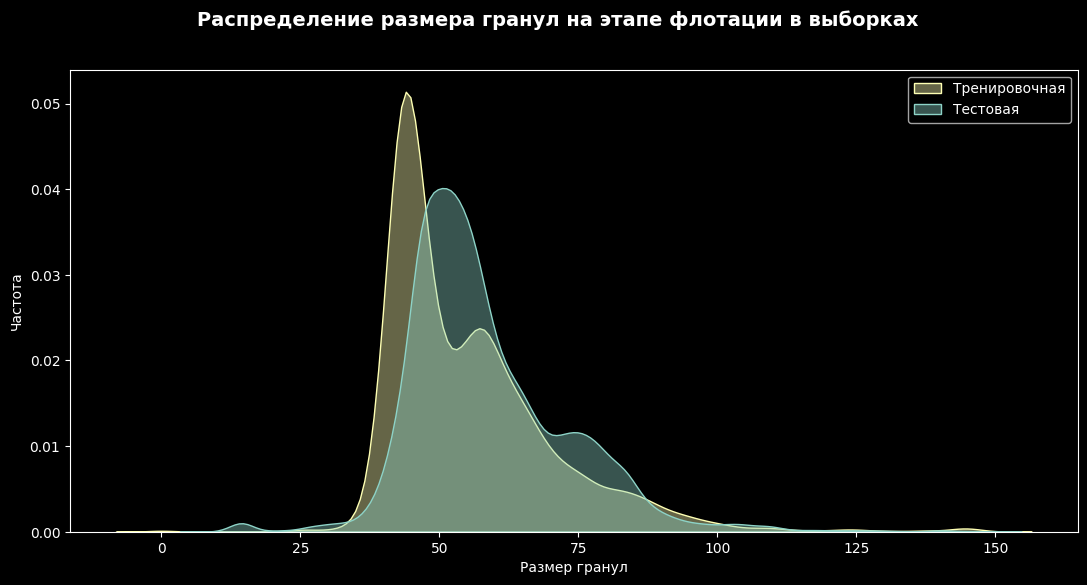

In [17]:
feeds_roug = pd.DataFrame({
    'train': train.loc[train['roug_in_feed_size'] < 150]['roug_in_feed_size'],
    'test': test.loc[test['roug_in_feed_size'] < 150]['roug_in_feed_size']
    })

fig, ax = plt.subplots(figsize=(13,6))
fig.suptitle('Распределение размера гранул на этапе флотации в выборках', fontsize=14, fontweight='bold')
sns.kdeplot(data=feeds_roug, fill=True, common_norm=False, alpha=0.4, ax=ax) 
ax.legend(['Тренировочная', 'Тестовая'])
ax.set_xlabel('Размер гранул')
ax.set_ylabel('Частота')
plt.show();

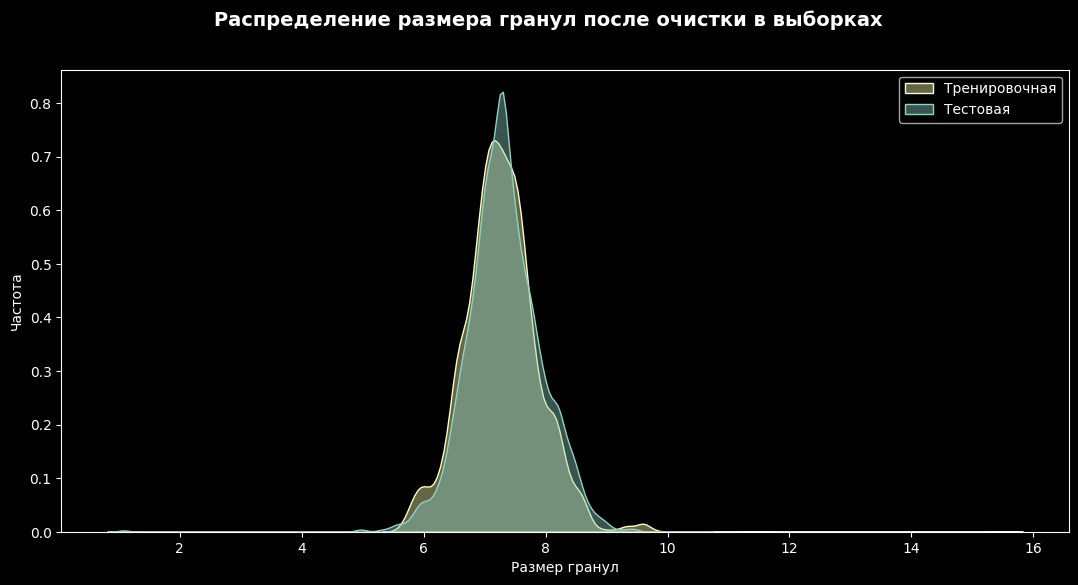

In [18]:
feeds_pr_cl = pd.DataFrame({
    'train': train.loc[train['pr_cl_in_feed_size'] < 150]['pr_cl_in_feed_size'],
    'test': test.loc[test['pr_cl_in_feed_size'] < 150]['pr_cl_in_feed_size']
    })

fig, ax = plt.subplots(figsize=(13,6))
fig.suptitle('Распределение размера гранул после очистки в выборках', fontsize=14, fontweight='bold')
sns.kdeplot(data=feeds_pr_cl, fill=True, common_norm=False, alpha=0.4, ax=ax) 
ax.legend(['Тренировочная', 'Тестовая'])
ax.set_xlabel('Размер гранул')
ax.set_ylabel('Частота')
plt.show();

Как видно на графике, распределения почти совпадают, различия незначительны

### Исследуем суммарную концентрацию всех веществ на разных стадиях

In [19]:
train['feed_conc'] = train['roug_in_feed_ag'] + train['roug_in_feed_pb'] + train['roug_in_feed_sol'] + train['roug_in_feed_au']
train['roug_conc'] = train['roug_out_conc_ag'] + train['roug_out_conc_pb'] + train['roug_out_conc_sol'] + train['roug_out_conc_au']
train['fin_conc'] = train['fin_out_conc_ag'] + train['fin_out_conc_pb'] + train['fin_out_conc_sol'] + train['fin_out_conc_au']

In [20]:
met_sum_conc = train[['feed_conc','roug_conc','fin_conc']].groupby(train.index.floor('D')).mean()
# met_sum_conc.iplot(title='Суммарная концентрация всех веществ на разных стадиях', xTitle='Дата', yTitle='Концентрация');

<img src="img/total_conc_all_subs_on_stages_by_time.png"
     alt="Суммарная концентрация всех веществ на разных стадиях"
     width="1200"
    >

В некоторых датах концентрация падает до нуля, посмотрим в гистограммах

In [21]:
met_sum_conc = train[['feed_conc','roug_conc','fin_conc']]
# met_sum_conc.iplot(kind='hist', title='Суммарная концентрация всех веществ на разных стадиях', xTitle='Концентрация', yTitle='количество');

<img src="img/total_conc_all_subs_on_stages_hist.png"
     alt="Суммарная концентрация всех веществ на разных стадиях (Гистограмма)"
     width="1200"
    >

Вывод

- Суммарная концентрация веществ возрастает после флотации
- после очистки среднее значение концентрации веществ остаётся на прежнем уровне, но снижается дисперсия и концентрация становится более предсказуемой
- необходимо удалить строки с нулевой концентрацией


In [22]:
before_delete = len(train)
train = train.loc[(train['roug_in_feed_au'] > 0) &
                  (train['roug_in_feed_ag'] > 0) & 
                  (train['roug_in_feed_pb'] > 0) & 
                  (train['roug_in_feed_sol'] > 0) & 
                  (train['roug_out_conc_au'] > 0) & 
                  (train['roug_out_conc_ag'] > 0) &
                  (train['roug_out_conc_pb'] > 0) & 
                  (train['roug_out_conc_sol'] > 0) &
                  (train['fin_out_conc_au'] > 0) & 
                  (train['fin_out_conc_ag'] > 0) &
                  (train['fin_out_conc_pb'] > 0) & 
                  (train['fin_out_conc_sol'] > 0)
                 ]
print(f'Удалено {before_delete - len(train)} объектов')

Удалено 583 объектов


Промежуточный вывод по блоку:

- Мы изучили концентрацию металлов на разных этапах и сделали вывод что концентрация золота возрастает на каждом этапе, серебра снижается, а свинец немного увеличивается после влотации
- изучили распределение гранул в выборках и сделали вывод что оно совпадает и не испортит результаты
- значения имеются за 2/3 года а за последнюю треть (с сентября и до конца года) отсутствуют
- Суммарная концентрация веществ возрастает после флотации
- после очистки среднее значение концентрации веществ остаётся на прежнем уровне, но снижается дисперсия и концентрация становится более предсказуемой
- имеются выбросы вплоть до нулевых значений, которые мы удалили

## Модель

### Напишем функцию для вычисления итоговой sMAPE

Припомним формулы из описания

$$ {sMAPE} = \frac{1}{N} \sum_{i=1}^{N} \frac{|y_i - \hat{y_i}|}{(|y_i| + |\hat{y_i}|) / 2} * 100\% $$

$$ {sMAPE} = 25\% * {sMAPE(rougher)} + 75\% * {sMAPE(final)} $$

In [23]:
def smape(y, y_pred):
    return 1 / len(y) * sum(abs(y - y_pred) / ((abs(y) + abs(y_pred)) / 2)) * 100

def fin_smape(roug_smape, fin_smape):
    return 0.25 * roug_smape + 0.75 * fin_smape

### Обучение и оценка качества моделей

#### Разобьём датасет на выборки

Для построения модели предсказания эффективности на этапе флотации, нам необходимо использовать только параметры связанные с этим этапом.

Сделаем список этих параметров

In [24]:
col_for_roug_model = [col for col in train[col_for_model].columns if col.startswith('roug')]

roug_train_x = train[col_for_roug_model]
roug_train_y = train['roug_out_recovery']
roug_test_x = test[col_for_roug_model]
roug_test_y = full.loc[test.index, 'roug_out_recovery']

fin_train_x = train[col_for_model]
fin_train_y = train['fin_out_recovery']
fin_test_x = test
fin_test_y = full.loc[test.index, 'fin_out_recovery']

if set(roug_train_x) != set(roug_test_x):
    print('Ошибка! Признаки в тренировочной и тестовой выборках для модели рассчета эффективности на этапе флотации не совпадают')
elif set(fin_train_x) != set(fin_test_x):
    print('Ошибка! Признаки в тренировочной и тестовой выборках для модели рассчета эффективности не совпадают')
else:
    print('Признаки в тренировочной и тестовой выборках совпадают')

Признаки в тренировочной и тестовой выборках совпадают


In [25]:
# roug_train_x.iplot(kind='hist', title='проверка параметров перед обучением модели', xTitle='Значение', yTitle='Концентрация');

<img src="img/check_roug_features_met_feed.png"
     alt="Checking Rougher features before model training (feed metall concentration)"
     width="1200"
    >

<img src="img/check_roug_features_rate_and_soze_feed.png"
     alt="Checking Rougher features before model training (feed rate and size)"
     width="1200"
    >

<img src="img/check_roug_features_fb10-11.png"
     alt="Checking Rougher features before model training (feedbank10 &11 parameters)"
     width="1200"
    >

<img src="img/check_roug_features_fb10_air.png"
     alt="Checking Rougher features before model training (feedbank10 air)"
     width="1200"
    >

<img src="img/check_roug_features_fb10_lvl.png"
     alt="Checking Rougher features before model training (feedbank10 level)"
     width="1200"
    >

In [26]:
# fin_train_x.iplot(kind='hist', title='проверка параметров перед обучением финальной модели', xTitle='Значение', yTitle='Концентрация');

<img src="img/check_fin_cl_in_sulfate.png"
     alt="проверка параметров перед обучением финальной модели (input sulfate)"
     width="1200"
    >

<img src="img/check_fin_cl_in.png"
     alt="проверка параметров перед обучением финальной модели (input parameters)"
     width="1200"
    >

<img src="img/check_fin_cl_st_fb8_air.png"
     alt="проверка параметров перед обучением финальной модели (очистка 1, float bank 8 air)"
     width="1200"
    >

<img src="img/check_fin_cl_st_fb8_lvl.png"
     alt="проверка параметров перед обучением финальной модели (очистка 1, float bank 8 level)"
     width="1200"
    >

<img src="img/check_fin_roug_in_feed_met.png"
     alt="проверка параметров перед обучением финальной модели (Rougher input metals)"
     width="1200"
    >

<img src="img/check_fin_roug_in_feed_rate_and_size.png"
     alt="проверка параметров перед обучением финальной модели (Rougher input rate & size)"
     width="1200"
    >

<img src="img/check_fin_roug_in_fb10-11.png"
     alt="проверка параметров перед обучением финальной модели (Rougher input float bank 10 & 11 sulfate & xanxhatte)"
     width="1200"
    >

<img src="img/check_fin_roug_st_fb10_air.png"
     alt="проверка параметров перед обучением финальной модели (Rougher float bank 10 air)"
     width="1200"
    >
    
<img src="img/check_fin_roug_st_fb10_lvl.png"
     alt="проверка параметров перед обучением финальной модели (Rougher float bank 10 level)"
     width="1200"
    >

<img src="img/check_fin_sc_fb2-6_a-b_air.png"
     alt="проверка параметров перед обучением финальной модели (очистка 2, float bank 2-6 air)"
     width="1200"
    >

<img src="img/check_fin_sc_fb2-6_a-b_lvl.png"
     alt="проверка параметров перед обучением финальной модели (очистка 2, float bank 2-6 level)"
     width="1200"
    >

#### Создадим KFold функцю

Мы строим разные модели и хотим быть уверены, что каждый раз при кросс валидации работаем с одинаково разбитыми данными. Для этого создадим KFold объект

In [27]:
kf = KFold(n_splits=5, random_state=1337, shuffle=True)

#### Создадим Scoring объект для использования его в кросс валидации

In [28]:
scor = make_scorer(smape, greater_is_better=False)

## Линейная регресия

In [29]:
# Масштабируем фичи
roug_scaler = StandardScaler()
fin_scaler = StandardScaler()
roug_scaler.fit(roug_train_x)
fin_scaler.fit(fin_train_x)

roug_train_x_scaled = pd.DataFrame(roug_scaler.transform(roug_train_x), columns=col_for_roug_model)
fin_train_x_scaled = pd.DataFrame(fin_scaler.transform(fin_train_x), columns=col_for_model)
roug_test_x_scaled = pd.DataFrame(roug_scaler.transform(roug_test_x), columns=col_for_roug_model)
fin_test_x_scaled = pd.DataFrame(fin_scaler.transform(fin_test_x), columns=col_for_model)

# обучим модель и проверим её кросс валидацией
lr_roug_model = LinearRegression()
lr_fin_model = LinearRegression()

lr_roug_smape = cross_val_score(lr_roug_model,
                                roug_train_x_scaled, 
                                roug_train_y, 
                                scoring = scor,
                                cv = kf,
                                n_jobs = -1).mean()

lr_fin_smape = cross_val_score(lr_fin_model, 
                               fin_train_x_scaled,
                               fin_train_y, 
                               scoring = scor,
                               cv = kf,
                               n_jobs = -1).mean()

lr_final_smape = fin_smape(abs(lr_roug_smape), abs(lr_fin_smape))

print('Linear Regression:')
print(f'sMAPE на этапе флотации = {round(abs(lr_roug_smape), 2)}')
print(f'sMAPE на финальном этапе = {round(abs(lr_fin_smape), 2)}')
print(f'sMAPE = {round(lr_final_smape, 2)}')

Linear Regression:
sMAPE на этапе флотации = 5.18
sMAPE на финальном этапе = 8.03
sMAPE = 7.32


## RandomForest

Для подбора параметров используем метод RandomizedSearchCV со следующей сеткой параметров:

In [30]:
rf_params = {'random_state': [1337],
             'n_estimators': [900, 1000, 1100],
             'max_depth': [20,24],
             'min_samples_split' : [1,2,3],
             'min_samples_leaf' : [1,2,3]
             }

In [31]:
rf_roug_model = RandomForestRegressor()

rf_roug_rndsch = RandomizedSearchCV(rf_roug_model,
                                   param_distributions = rf_params,
                                   n_iter = 10,
                                   scoring = scor,
                                   cv = kf,
                                   random_state = 1337,
                                   n_jobs = -1
                                   )

rf_roug_rndsch.fit(roug_train_x, roug_train_y)

rf_roug_smape = abs(rf_roug_rndsch.best_score_)

print('Лучшее значение sMAPE модели случайного леса на этапе подготовки сырья к флотации:')
print(rf_roug_smape)
print('при следующих параметрах:')
print(rf_roug_rndsch.best_params_)

Лучшее значение sMAPE модели случайного леса на этапе подготовки сырья к флотации:
2.7019707242847
при следующих параметрах:
{'random_state': 1337, 'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 24}


In [32]:
rf_fin_model = RandomForestRegressor()

rf_fin_rndsch = RandomizedSearchCV(rf_fin_model,
                                   param_distributions = rf_params,
                                   n_iter = 10,
                                   scoring = scor,
                                   cv = kf,
                                   random_state = 1337,
                                   n_jobs = -1
                                   )

rf_fin_rndsch.fit(fin_train_x, fin_train_y)

rf_fin_smape = abs(rf_fin_rndsch.best_score_)

print('Лучшее значение sMAPE модели случайного леса на этапе подготовки сырья к флотации:')
print(rf_fin_smape)
print('при следующих параметрах:')
print(rf_fin_rndsch.best_params_)

Лучшее значение sMAPE модели случайного леса на этапе подготовки сырья к флотации:
5.489161058262947
при следующих параметрах:
{'random_state': 1337, 'n_estimators': 1100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 24}


In [33]:
rf_final_smape = fin_smape(rf_roug_smape, rf_fin_smape)

print('RandomForest:')
print(f'sMAPE на этапе флотации = {round(rf_roug_smape, 2)}')
print(f'sMAPE на финальном этапе = {round(rf_fin_smape, 2)}')
print(f'sMAPE = {round(rf_final_smape, 2)}')

RandomForest:
sMAPE на этапе флотации = 2.7
sMAPE на финальном этапе = 5.49
sMAPE = 4.79


#### Сравним модели

In [34]:
model_names = ['Linear Regression', 
               'Random Forest',  
               ]
             
final_smape = [lr_final_smape,
               rf_final_smape,
               ]

models_dif = pd.DataFrame({'Модель':model_names,
                           'sMAPE':final_smape
                           })
models_dif

,Модель,sMAPE
0,Linear Regression,7.32
1,Random Forest,4.79


Модель Случайного леса показала лучший результат на метрике sMAPE

#### Тестирование лучшей модели

In [35]:
rf_roug_model = RandomForestRegressor(random_state = rf_roug_rndsch.best_params_['random_state'],
                                      n_estimators = rf_roug_rndsch.best_params_['n_estimators'],
                                      min_samples_split = rf_roug_rndsch.best_params_['min_samples_split'],
                                      min_samples_leaf = rf_roug_rndsch.best_params_['min_samples_leaf'],
                                      max_depth = rf_roug_rndsch.best_params_['max_depth'])

rf_fin_model = RandomForestRegressor(random_state = rf_fin_rndsch.best_params_['random_state'],
                                      n_estimators = rf_fin_rndsch.best_params_['n_estimators'],
                                      min_samples_split = rf_fin_rndsch.best_params_['min_samples_split'],
                                      min_samples_leaf = rf_fin_rndsch.best_params_['min_samples_leaf'],
                                      max_depth = rf_fin_rndsch.best_params_['max_depth'])

rf_roug_model.fit(roug_train_x, roug_train_y)
rf_fin_model.fit(fin_train_x, fin_train_y)

rf_roug_pred = rf_roug_model.predict(roug_test_x)
rf_fin_pred = rf_fin_model.predict(fin_test_x)

test_rough_smape = smape(roug_test_y, rf_roug_pred)
test_fin_smape = smape(fin_test_y, rf_fin_pred)
test_final_smape = fin_smape(test_rough_smape, test_fin_smape)

print('Случайный лес - Тестовая выборка:')
print(f'sMAPE на этапе флотации = {round(test_rough_smape, 2)}')
print(f'sMAPE на финальном этапе = {round(test_fin_smape, 2)}')
print(f'sMAPE = {round(test_final_smape, 2)}')

Случайный лес - Тестовая выборка:
sMAPE на этапе флотации = 8.02
sMAPE на финальном этапе = 9.61
sMAPE = 9.22


####  Сравним с константной Dummy моделью

In [36]:
dummy_roug_model = DummyRegressor(strategy="median")
dummy_fin_model = DummyRegressor(strategy="median")

dummy_roug_model.fit(roug_train_x, roug_train_y)
dummy_fin_model.fit(fin_train_x, fin_train_y)

dummy_roug_pred = dummy_roug_model.predict(roug_test_x)
dummy_fin_pred = dummy_fin_model.predict(fin_test_x)

dummy_roug_smape = smape(roug_test_y, dummy_roug_pred)
dummy_fin_smape = smape(fin_test_y, dummy_fin_pred)

dummy_final_smape = fin_smape(dummy_roug_smape, dummy_fin_smape)

print('Константная dummy регрессия:')
print(f'sMAPE на этапе флотации = {round(dummy_roug_smape, 2)}')
print(f'sMAPE на финальном этапе = {round(dummy_fin_smape, 2)}')
print(f'sMAPE = {round(dummy_final_smape, 2)}')

Константная dummy регрессия:
sMAPE на этапе флотации = 8.48
sMAPE на финальном этапе = 9.69
sMAPE = 9.38


## Вывод

Проделанная работа:
- загружены и изучены данные
- в данных обнаружены и убраны пропуски
- проверенны расчеты эффективности обогащения в данных - соотетствуют полученым по формуле
- проанализированы признаки тестовой выборки и отсутствующие в ней признаки не используются при обучении моделей на тренировочной выборке
- исследована концентрация металлов на разных этапах, сделаны выводы о том что концентрация золота растёт с каждым этапом, серебра падает, а свинец немного растёт после флотации
- так же на этом этапе выявлены аномальные данные в которых концентрация металлов нулевая - данные строки удалены
- исследован размер гранул на тренировочной и тестовой выборках - распределение совпадает
- написаны функции для расчета метрик sMAPE
- для поиска лучшей модели использовали K-FOLD кросс валидацию
- обучена модель линейной регрессии. Метрика sMAPE на кросс валидации:
    - `sMAPE на этапе флотации` = 5.18
    - `sMAPE на финальном этапе` = 8.03
    - `sMAPE` = 7.32
- обучена модель случайного леса. Метрика sMAPE на кросс валидации:
    - `sMAPE на этапе флотации` = 2.7
    - `sMAPE на финальном этапе` = 5.49
    - `sMAPE` = 4.79
- Лучшая модель из обученных оказалась модель случайного леса. Метрика `sMAPE` на тестовой выборке:
    - `sMAPE на этапе флотации` = 8.02
    - `sMAPE на финальном этапе` = 9.61
    - `sMAPE` = 9.22
- обучена константная dummy модель для проверки нашей модели на адекватность. Её метрика `sMAPE` на тестовой выборке:
    - `sMAPE на этапе флотации` = 8.48
    - `sMAPE на финальном этапе` = 9.69
    - `sMAPE` = 9.38
    
Наша модель показывает `sMAPE` лучше чем dummy модель на 0.16